In [2]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import seaborn as sns

In [3]:
pl.__version__

'1.0.0'

In [4]:
lgb.__version__

'4.5.0'

In [5]:
EXP_NAME = "e100-lightgbm"
COMPETITION_NAME = "atmacup17"

DATA_PATH = "data"
ENV_PATH = "env_file"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"
TARGET_COL = "Recommended IND"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
# UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

In [6]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return "kernel", f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return "nohup", f"../../{base_path}"
    elif cwd == f"/content":
        print("Google Colab!")
        return "colab", f"/content/drive/MyDrive/Kaggle/{COMPETITION_NAME}/{base_path}"
    elif cwd.startswith("/home/shinichiro.saito"):
        print("GCP!")
        return "GCP", f"/home/shinichiro.saito/{COMPETITION_NAME}/{base_path}"
    else:
        raise Exception("Unknown environment")


ENV_NAME, DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
_, MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)
_, ENV_PATH = resolve_path(ENV_PATH)

/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/data
/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/trained_models/e100-lightgbm
/home/shinichiro.saito/atmacup17/exp
GCP!


In [7]:
import json

with open(f"{DATA_PATH}/rec_stratified_fold.json") as f:
    label_stratified_fold = json.load(f)

In [14]:
train = pl.read_csv(f"{DATA_PATH}/train.csv")
test = pl.read_csv(f"{DATA_PATH}/test.csv")
clothing_master = pl.read_csv(f"{DATA_PATH}/clothing_master.csv")

train = train.join(clothing_master, on="Clothing ID", how="left").with_columns(
    pl.col("Clothing ID")
    .replace(label_stratified_fold)
    .alias("fold"),  # foldを追加する
    pl.col("Clothing ID").cast(pl.String),
)
test = test.join(clothing_master, on="Clothing ID", how="left").with_columns(
    pl.col("Clothing ID").cast(pl.String),
)

In [15]:
train

Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,fold
str,i64,str,str,i64,i64,i64,str,str,str,i64
"""0""",25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",0
"""0""",39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",0
"""0""",42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",0
"""0""",45,null,"""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts""",0
"""0""",57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts""",0
…,…,…,…,…,…,…,…,…,…,…
"""232""",57,"""Runs big on top""",null,3,1,5,"""General""","""Dresses""","""Dresses""",2
"""232""",58,null,"""I loved the dress, but just no…",1,1,5,"""General""","""Dresses""","""Dresses""",2
"""232""",60,"""I was really disappointed""","""I was really hoping this dress…",2,0,7,"""General""","""Dresses""","""Dresses""",2


In [16]:
USE_COL = [
    "Clothing ID",
    "Age",
    "Positive Feedback Count",
    "Division Name",
    "Department Name",
    "Class Name",
]
CATEGORICAL_FEATURE = ["Clothing ID", "Division Name", "Department Name", "Class Name"]
TARGET_COL = "Recommended IND"
FOLD_NUM = 3
SEED = 42

In [17]:
# Categorical型への変換
train = train.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [18]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "binary",
    "metric": "auc",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [19]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.708582	valid_1's auc: 0.578818
[200]	training's auc: 0.727675	valid_1's auc: 0.581371
[300]	training's auc: 0.747166	valid_1's auc: 0.580528
Early stopping, best iteration is:
[240]	training's auc: 0.736558	valid_1's auc: 0.582216
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.724313	valid_1's auc: 0.56873
Early stopping, best iteration is:
[14]	training's auc: 0.691058	valid_1's auc: 0.572121
Start fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.70504	valid_1's auc: 0.596171
Early stopping, best iteration is:
[54]	training's auc: 0.689525	valid_1's auc: 0.600431


In [21]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.5822161058332593
fold 1 Score: 0.5721209260731319
fold 2 Score: 0.6004308697037273


In [22]:
model

In [28]:
cv_score = roc_auc_score(train.get_column(TARGET_COL), oof)
cv_score

0.5754881470348668

<Axes: >

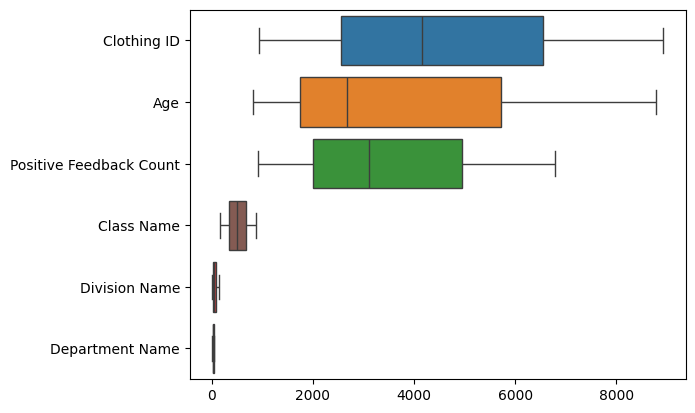

In [25]:
import pandas as pd

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [26]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred

array([0.84791296, 0.85396492, 0.85249228, ..., 0.79781903, 0.76863834,
       0.7927655 ])

In [31]:
import os

os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

sample_submission = pl.read_csv(f"{DATA_PATH}/sample_submission.csv")

if DEBUG:
    sample_submission = sample_submission.head(100)

(
    sample_submission.with_columns(pl.Series(pred).alias("target")).write_csv(
        f"{MODEL_OUTPUT_PATH}/submission_{EXP_NAME}_cv{cv_score:.4f}.csv"
    )
)